In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 1us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [7]:
train_targets[0]

15.2

In [12]:
# Normalização feature-wise: usada as características nao utilizam a mesma escala
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

# Note: a media e desvio padrao utilizados para normalizar os dados de teste
# foram os computados a partir dos dados de treino. Nunca deve-se utilizar
# nada computado a partir dos dados de teste.

mean

array([ 7.83201886e-18, -1.20915379e-17, -3.29769215e-17,  2.81403064e-16,
        4.39692287e-18,  7.41980734e-18,  1.09923072e-17, -1.09923072e-18,
        1.51144224e-17, -2.55571142e-17,  2.41830758e-17, -1.23663456e-18,
       -1.20915379e-17])

In [13]:
# Dados normalizados
test_data[0]

array([ 1.55369355, -0.48361547,  1.0283258 , -0.25683275,  1.03838067,
        0.23545815,  1.11048828, -0.93976936,  1.67588577,  1.5652875 ,
        0.78447637, -3.48459553,  2.25092074])

In [22]:
# Em geral, quanto menos dados de treino se tem, pior será a taxa de overfitting
# Usar uma rede neural menor é uma das formas de mitigar o overfitting.

#Construindo e compilando a rede neural

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation ='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
    return model

# A rede termina com uma camada de um unico neuronio, e sem função de ativação
# Será uma camada linear. Esta é uma típica configuração para scalar regression.
# A função de perda mse é amplamente usada para problemas de regressão
# mae = mean absolute error = o valor absoluto da diferença entre as previsões e os alvos.
# mae = 0.5 --> erro médio das previsões  = $500

In [26]:
# Usando k-validation: dividir o data train em k pedaços e treinar
# k vezes, onde em cada vez, um dos pedaços é utilizados para validação
# e o restante para treinamento. A taxa de validação é a média das k taxas.

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data [:i*num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis = 0)
    
    model = build_model()
    model.fit(partial_train_data,
             partial_train_targets,
             epochs = num_epochs,
             batch_size = 1,
             verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [27]:
all_scores

[2.071552038192749, 2.376553773880005, 2.485138177871704, 2.652003526687622]

In [28]:
np.mean(all_scores)

2.39631187915802

In [32]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [38]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

<function matplotlib.pyplot.show(close=None, block=None)>

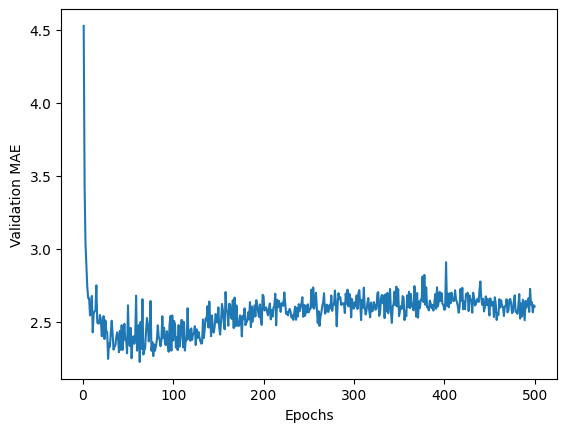

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show

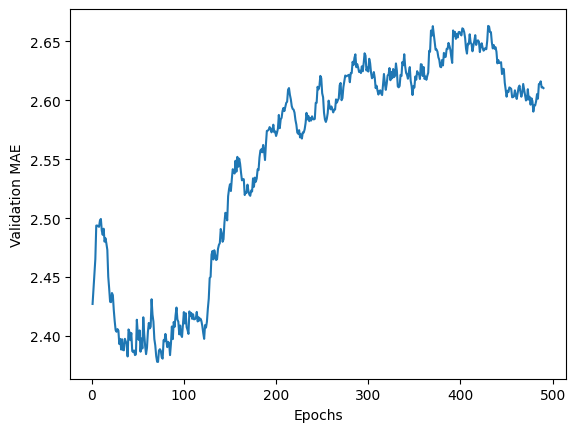

In [45]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
        

In [47]:
model = build_model()
model.fit(train_data, train_targets,
         epochs = 80, batch_size = 16, verbose = 0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.7982 - mae: 2.6899


In [49]:
test_mae_score

2.6899116039276123